<h1><center>d18O Isotope Ratio Changes in the Gulf of Maine</center></h1>

<center>Here, I'll perform segmented regression on the d18O isotope ratio</center>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
from cartopy import config
from IPython.display import clear_output
from IPython.display import display, HTML
from scipy import stats
from scipy import optimize
import numpy.polynomial.polynomial as npoly
import matplotlib.gridspec as gridspec
from scipy import interpolate

%run /home/ncresswell/Desktop/AzoresHigh_850-2005/MyFunctions/DataAnalyzing.py

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

First, load d18o isotope record

In [2]:
d18o = xr.open_dataarray('d18O_GoM_clams')

Now interpolate record to fill in patchy data

In [4]:
#remove missing values 
d18o_no_missing=d18o[np.logical_not(np.isnan(d18o))]

#interpolate using scipy library
f_d18o = interpolate.interp1d(d18o_no_missing['time'].values,d18o_no_missing.values)

#create interpolation over period in question 
resampled_time = np.arange(1694,2014,1)
d18o_interp = f_d18o(resampled_time)

In [5]:
d18O_interpolated = xr.DataArray(d18o_interp,
                                 coords=[resampled_time], 
                                 dims=['time'], 
                                 attrs={'Info':'Temporally interpolated d18O isotope ratio taken from clams in the Gulf of Maine',
                                        'Interpolation':'scipy.interpolate(linear)'})

Here, I use segmented regression on the interpolated data 

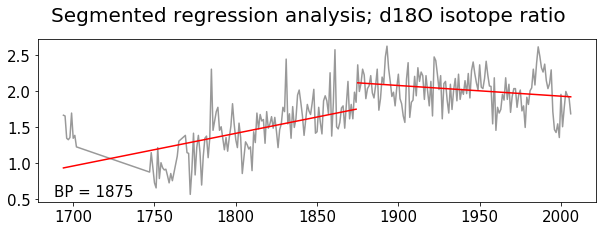

In [6]:
###########################################################################################################################
######################################        FUNCTION DEFINITIONS            #############################################
###########################################################################################################################

def f(breakpoints, x, y, fcache,num_breakpoints=1):
    breakpoints = tuple(map(int, sorted(breakpoints)))
    if breakpoints not in fcache:
        total_error = 0
        for f, xi, yi in find_best_piecewise_polynomial(breakpoints, x, y,num_breakpoints=num_breakpoints):
            total_error += ((f(xi) - yi)**2).sum()
        fcache[breakpoints] = total_error
    # print('{} --> {}'.format(breakpoints, fcache[breakpoints]))
    return fcache[breakpoints]

def find_best_piecewise_polynomial(breakpoints, x, y,num_breakpoints=1):
#     print('passed breakpoints are: ', breakpoints)
    breakpoints = tuple(map(int, sorted(breakpoints)))
#     print('processed breakpoints are: ', breakpoints)
    xs = np.split(x, breakpoints)
#     print('xs is ',xs)
#     print('')
    ys = np.split(y, breakpoints)
    result = []
    for xi, yi in zip(xs, ys):
        if len(xi) < 2: continue
        coefs = npoly.polyfit(xi, yi, 1)
        f = npoly.Polynomial(coefs)
        result.append([f, xi, yi])
    return result

###########################################################################################################################
############################################   CALCULATIONS AND DISPLAY    ################################################
###########################################################################################################################

fig, ax = plt.subplots(figsize = (10,3))

num_breakpoints = 1

#identify arrays to be used for segmented regression analysis
x = resampled_time[:-7]
y = d18o_interp[:-7]

#use brute force to find optimal breakpoint[s]
breakpoints = optimize.brute(
    f, [slice(1, len(x), 1)]*num_breakpoints, args=(x, y, {},num_breakpoints), finish=None)
# plot raw data 
ax.plot(x, y, c='grey',alpha=.8)
#plot segmented regression 
if num_breakpoints > 1:
    for current_f, xi, yi in find_best_piecewise_polynomial(breakpoints, x, y,num_breakpoints=num_breakpoints):
        x_interval = np.array([xi.min(), xi.max()])
        ax.plot(x_interval, currentf(x_interval), 'r-')
        ax.set_title('BPs = '+str(int(breakpoints+x[0])),x=.1,y=.0,fontsize=15)
elif num_breakpoints == 1:
    for current_f, xi, yi in find_best_piecewise_polynomial([breakpoints], x, y,num_breakpoints=num_breakpoints):
        x_interval = np.array([xi.min(), xi.max()])
        ax.plot(x_interval, current_f(x_interval), 'r-')
        ax.set_title('BP = '+str(int(breakpoints+x[0])),x=.1,y=.0,fontsize=15)

ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=15)
ax.set_yticklabels(ax.get_yticks(),fontsize=15)

fig.suptitle('Segmented regression analysis; d18O isotope ratio',fontsize=20,y=1.03);